In [17]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm # progress bar
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pmdarima as pm

In [6]:
# Haal het dataframe op
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_pc4 = pd.read_hdf('pc4_verbruiksdata.h5')

In [7]:
sel_postcode = 5501
# Kies een pc4 en vertaal naar een simpel x,y model (index = datum, verbruik is de y-waarde)
df_pc4 = df_pc4[df_pc4.PC4 == sel_postcode]
df_pc4.head()

,RES,PC4,VERBRUIK
DATUM,,,
2010-01-01,Metropoolregio Eindhoven,5501,35.638680
2010-01-02,Metropoolregio Eindhoven,5501,38.445606
2010-01-03,Metropoolregio Eindhoven,5501,36.335540
2010-01-04,Metropoolregio Eindhoven,5501,37.050146
2010-01-05,Metropoolregio Eindhoven,5501,36.730582


In [8]:
df_pc4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2010-01-01 to 2021-12-31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RES       4383 non-null   object 
 1   PC4       4383 non-null   int64  
 2   VERBRUIK  4383 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 137.0+ KB


In [9]:
df_pc4["year"] = df_pc4.index.year
df_pc4["month"] = df_pc4.index.month
df_pc4["day"] = df_pc4.index.day
df_pc4["quarter"] = df_pc4.index.quarter
df_pc4.head()

,RES,PC4,VERBRUIK,year,month,day,quarter
DATUM,,,,,,,
2010-01-01,Metropoolregio Eindhoven,5501,35.638680,2010,1,1,1
2010-01-02,Metropoolregio Eindhoven,5501,38.445606,2010,1,2,1
2010-01-03,Metropoolregio Eindhoven,5501,36.335540,2010,1,3,1
2010-01-04,Metropoolregio Eindhoven,5501,37.050146,2010,1,4,1
2010-01-05,Metropoolregio Eindhoven,5501,36.730582,2010,1,5,1


In [10]:
# Maak een train en test set.
split_date = datetime(2020,1,1)
df_train, df_test = df_pc4[df_pc4.index < split_date], df_pc4[df_pc4.index >= split_date]
X_train, X_test = df_train.VERBRUIK.values, df_test.VERBRUIK.values

# Automatisch zoeken van hyperparameters

In de module pmdarima zit auto_arima functie die ondersteunt bij het zoeken naar de beste hyperparameters (p,d,q) voor het ARIMA algoritme. De auto_arima gebruikt de AIC (Akaike Information Criterion) om te bepalen welke combinatie van hyperparameters het beste werkt.

Voorwaarde is wel dat de data voldoende stationair is.

In [80]:
# Duurt even om alle mogelijkheden te testen. Doe alleen als de set veranderd is
# Je moet pmdarima installeren met pip om dit te laten werken
autoModel = pm.auto_arima(X_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True)
autoModel.fit(X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7084.268, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8573.809, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7500.097, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7103.627, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8571.814, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6673.923, Time=2.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7079.696, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7080.410, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7083.633, Time=0.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7079.794, Time=0.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7082.327, Time=1.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6602.072, Time=1.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5968.082, Time=4.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6570.642, Time=3.95 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<Figure size 432x288 with 0 Axes>

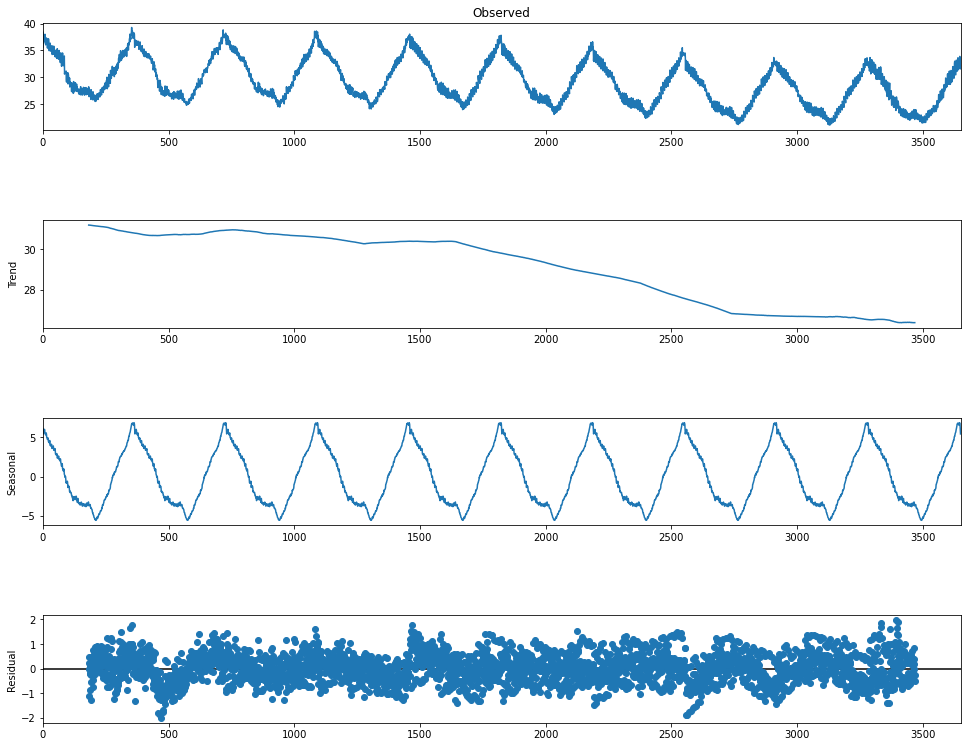

In [81]:
# Zit er een seasonal component in?
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(X_train, model='additive', freq=365)

fig = pyplot.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# Bepaal nauwkeurigheid model

Het (S)ARIMA model berekent de waarde van een voorspelling 1 dag vooruit. Door het model te trainen met een trainingsset die per iteratie steeds 1 dag langer wordt, kunnen we iedere waarde van de testset berekenen en vergelijken met de echte waarde om de nauwkeurigheid van het model te bepalen

We beginnen met een trainingsset tot en met 2019. De test set zijn dan alle dagen in 2020 en 2021. Dit vanwege de tijd die het kost om alle voorspellingen voor deze jaren te bepalen. Per toegevoegde dag/iteratie zo'n 3-4 seconden.

In [82]:
warnings.filterwarnings('ignore')
best_order = (5,1,5)
history = X_train.tolist()
predictions = list()

for t in tqdm(range(len(X_test))):
    # Bereken de volgende lag. Kijk steeds 1 dag vooruit.
    # Alle voorspelling voor de test set worden in de lijst 'predictions' gezet
    # approximate_diffuse lost een LU decomposition error op
    model = SARIMAX(history, order=best_order, seasonal_order=(0,0,0,3), initialization='approximate_diffuse')
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0] # voorspelde waarde 1 dag vooruit
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)


100%|██████████| 731/731 [59:57<00:00,  4.92s/it]


In [83]:
# Sla de voorspellingen op. Voor gebruik verderop. 
np.save(f'{sel_postcode}_predictions', predictions)

In [11]:
predictions = np.load(f'{sel_postcode}_predictions.npy')
len (predictions)

731

# Bereken de MAPE

De Mean Average Percentage Error is gedefinieerd als:

$$
MAPE = \frac{1}{N}\sum_{t=1}^{N}|\frac{A_{t} - F_{t}}{A_{t}}| * 100,
$$

Waarbij $A_{t}$ de actuele waarde op tijdstip $t$ is, $F_{t}$ de voorspelde waarde en $N$ het aantal datapunten


In [31]:
sum = 0
def mean_absolute_percentage_error(y_true, y_pred):
    global sum
    for i, y in enumerate(y_true):
        portion = abs((y - y_pred[i]) / y)
        sum = sum + abs((y - y_pred[i]) / y)
    return sum / i * 100

In [32]:
mape = mean_absolute_percentage_error(X_test, predictions)
print (f"MAPE = {format(mape, '.1f')} %")

MAPE = 1.8 %


In [12]:
# Evalueer de voorspelling door de RMSE uit te rekenen
# Wellicht wordt de RMSE nog beter met andere hyper parameters
rmse = sqrt(mean_squared_error(X_test, predictions))
print(f'RMSE: {format(rmse, ".3f")}')

RMSE: 0.576


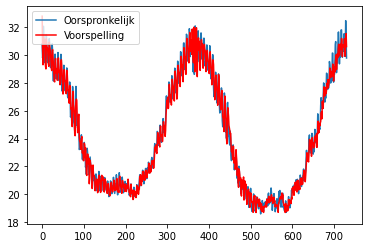

In [13]:
pyplot.plot(X_test, label="Oorspronkelijk")
pyplot.plot(predictions,color='red',label='Voorspelling')
pyplot.legend()

# Karakteristieken ARIMA
Onderzoek nog wat andere karakteristieken van het ARIMA model zoals de residuals, de verdeling van de residuals en de RSME

In [69]:
model = ARIMA(X_train, order=best_order)
model_fit = model.fit()
print (model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4018
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2739.001
Date:                Wed, 07 Apr 2021   AIC                           5500.003
Time:                        14:43:27   BIC                           5569.284
Sample:                             0   HQIC                          5524.556
                               - 4018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2500      0.004   -355.144      0.000      -1.257      -1.243
ar.L2         -0.5437      0.005   -103.195      0.000      -0.554      -0.533
ar.L3          0.5675      0.005    115.898      0.0

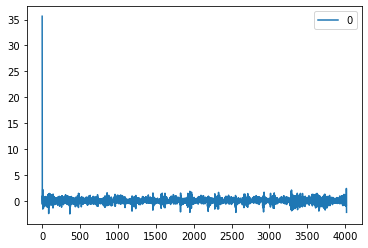

In [70]:
# Plot van de residuals. Ziet er eigenlijk wel goed uit, behalve dan de spike aan het begin. Startprobleem?
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

<AxesSubplot:ylabel='Density'>

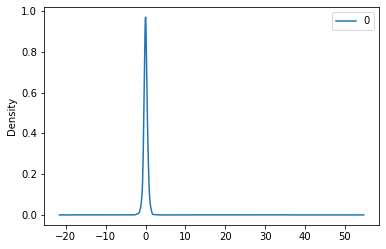

In [71]:
# En de dichtheid van de residuals; gaussische curve rondom 0. Lijkt ongeveer normaal verdeeld
residuals.plot.kde()

In [72]:
# Samenvatting van de statistiek
print(residuals.describe())

                 0
count  4018.000000
mean      0.011123
std       0.739860
min      -2.536084
25%      -0.257537
50%       0.002748
75%       0.272374
max      35.638680
